In [74]:
import pandas as pd
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.timeseries import LombScargle
from astropy.table import Table
from scipy.signal import savgol_filter as savgol
from pathlib import Path
from scipy import ndimage

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [32]:
tess_list = pd.read_csv('md_check.csv', index_col = 0)
k2_halo_stars = pd.read_csv('161_merged_by_epic.csv', sep = ",")[["Name", "Vmag", "Sp. Type", "EPIC ID"]]

In [33]:
stars_list = pd.merge(k2_halo_stars,tess_list, on='Name', how='inner')
stars_list = stars_list.drop_duplicates("EPIC ID").reset_index(drop = True)

In [34]:
tess_sectors = stars_list.filter(regex="^S\d+")
tess_sectors_sum = tess_sectors.sum(axis=1)
tess_sectors_sel = pd.DataFrame({'cam':tess_sectors_sum.values})

In [35]:
observed_stars = stars_list.loc[tess_sectors_sel.index[tess_sectors_sel['cam'] >=1]][["Name", "Vmag", "Sp. Type", "EPIC ID"]]

Porrima 200084004 No TESS data
Zaniah 200084005 No TESS data
21 Vir 200084006 No TESS data
FW Vir 200084007 No TESS data
HR 4837 200084008 No TESS data
HR 4591 200084009 No TESS data
HR 4613 200084010 No TESS data
HD 107794 200084011 No TESS data
45 Oph 200128908 No HALO data
HR 6366 200128913 No HALO data
Aldebaran 200173843 No TESS data
tet2 Tau 200173845 No TESS data
tet1 Tau 200173846 No TESS data
del3 Tau 200173849 No TESS data
ups Tau 200173848 No TESS data
rho Tau 200173851
11 Ori 200173853
HR 1427 200173855 No TESS data
15 Ori 200173854
75 Tau 200173852 No TESS data
97 Tau 200173857 No TESS data
HR 1684 200173856
56 Tau 200173861 No TESS data
81 Tau 200173860
53 Tau 200173864 No TESS data
HR 1585 200173858 No TESS data
80 Tau 200173866
51 Tau 200173865 No TESS data
HR 1403 200173867 No TESS data
89 Tau 200173868
HR 1576 200173871


98 Tau 200173870 No TESS data
99 Tau 200173862 No TESS data
105 Tau 200173869 No TESS data
HR 1554 200173874 No TESS data
HR 1385 200173875 No TESS data
HR 1741 200173873 No TESS data
HR 1633 200173872 No TESS data
HR 1755 200173876 No TESS data
kap Psc 200164167 No TESS data
83 Aqr 200164168 No TESS data
24 Psc 200164169 No TESS data
HR 8759 200164170 No TESS data
14 Psc 200164171 No TESS data
HR 8921 200164172 No TESS data
81 Aqr 200164173 No TESS data
HR 8897 200164174 No TESS data
eps Psc 200068392 No TESS data
Revati 200068393 No TESS data
80 Psc 200068394 No TESS data
42 Cet 200068399
33 Cet 200068395 No TESS data
60 Psc 200068396 No TESS data
73 Psc 200068397 No TESS data
WW Psc 200068398 No TESS data
HR 243 200068400 No TESS data
HR 161 200068401 No TESS data
Asellus Australis 200200356 No TESS data
Acubens  200200357 No TESS data
ksi Cnc 200200358 No TESS data
omi1 Cnc 200200360 No TESS data
eta Cnc 200200359 No TESS data
45 Cnc 200200728 No TESS data
omi2 Cnc 200200361 No TES

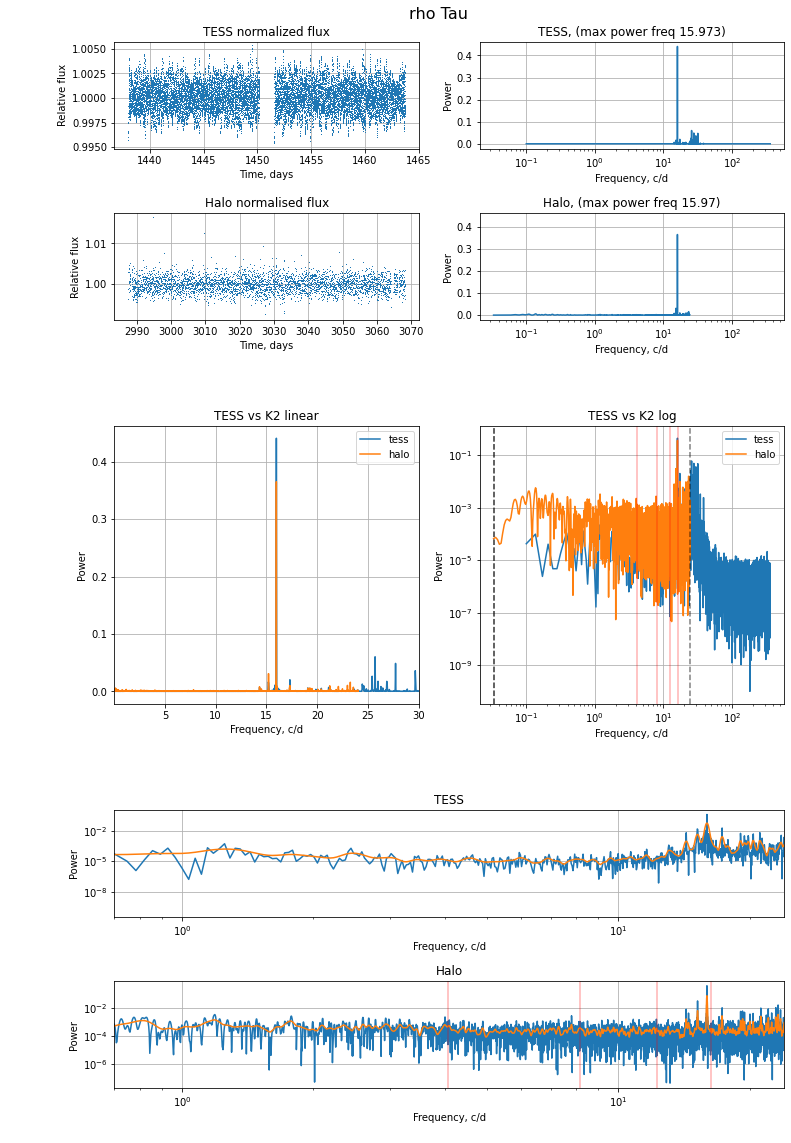

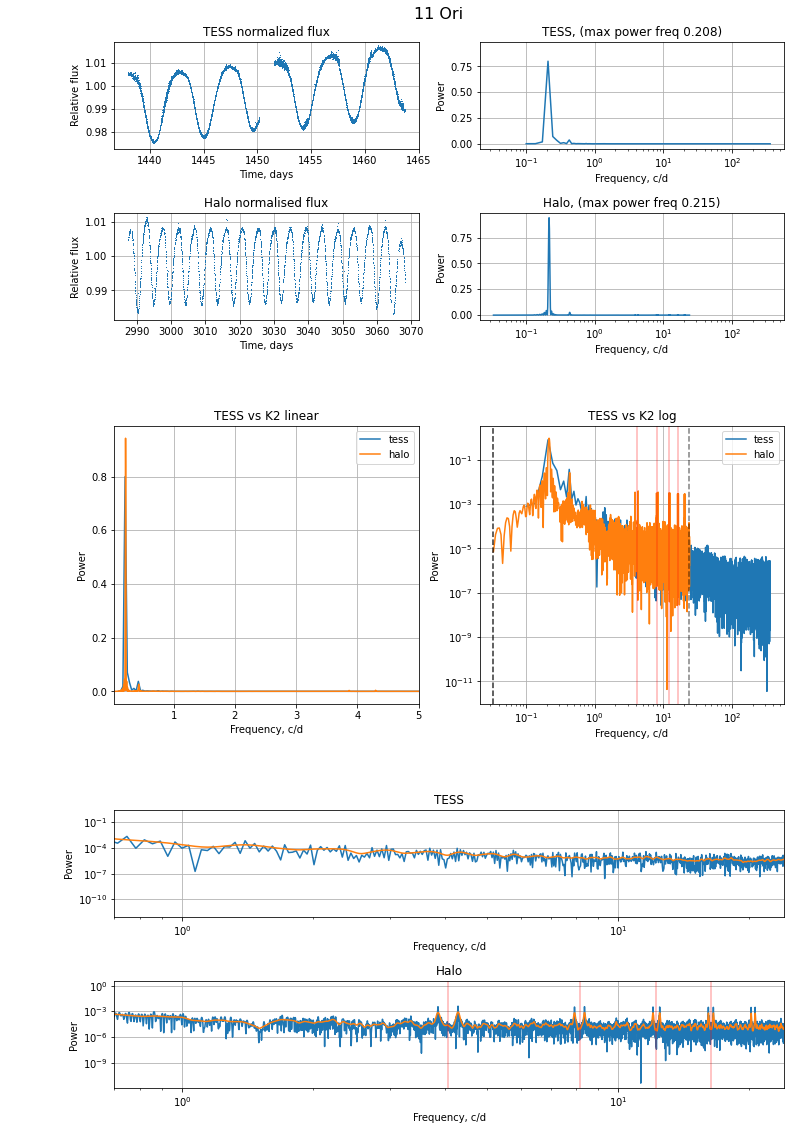

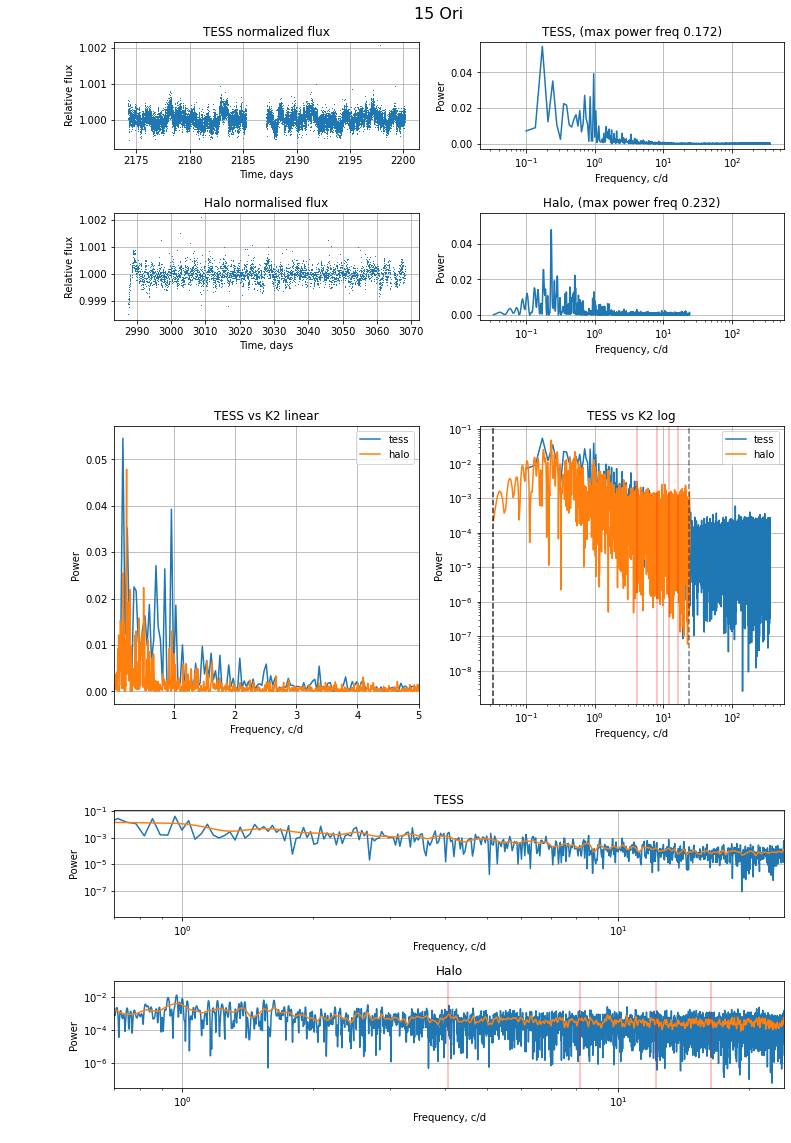

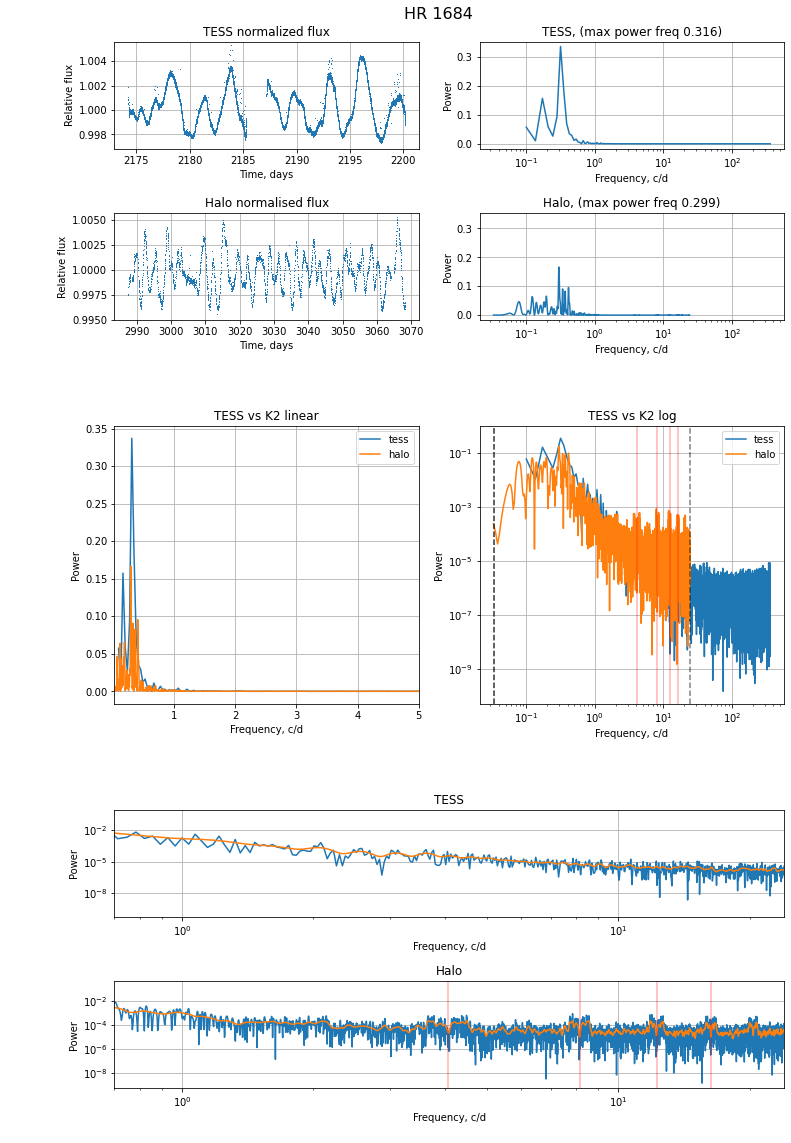

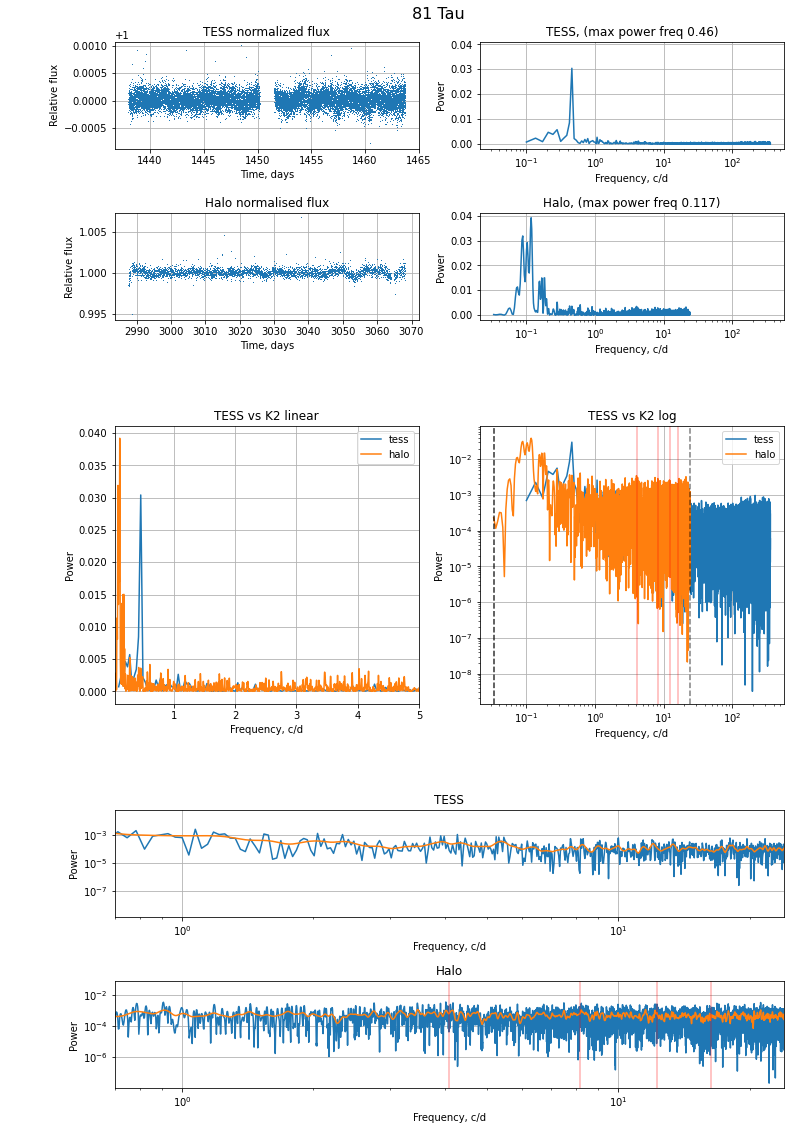

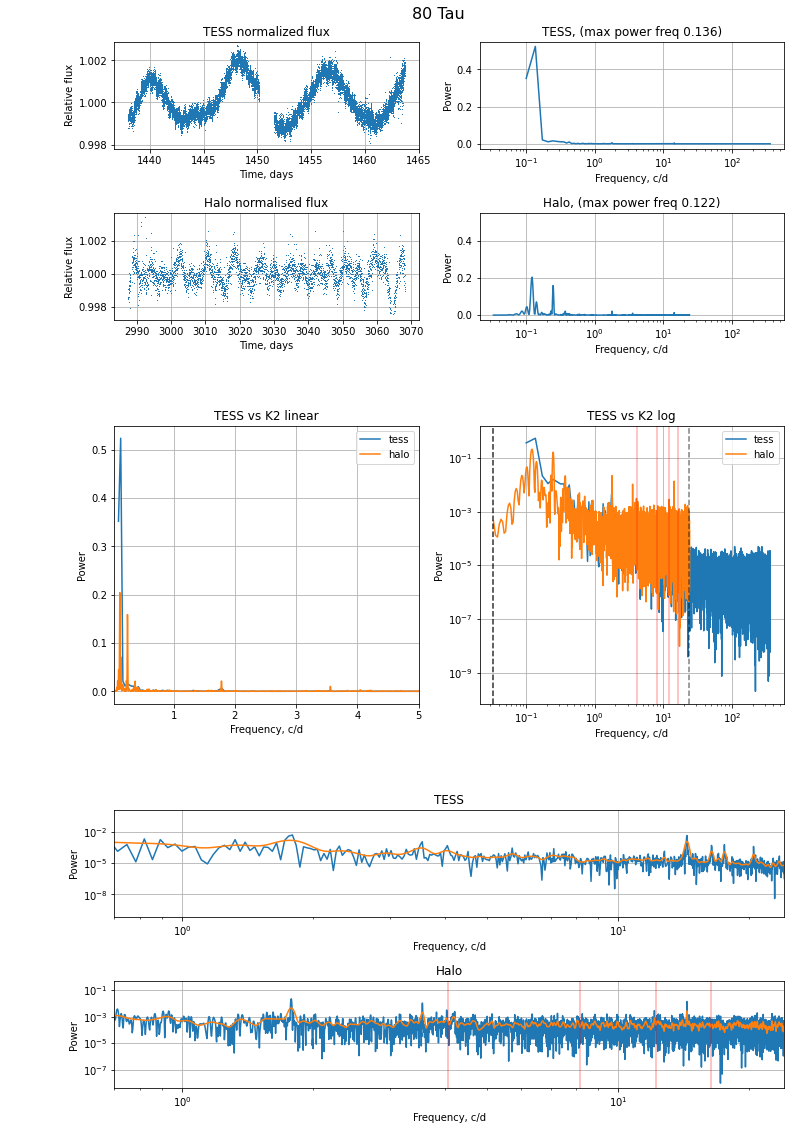

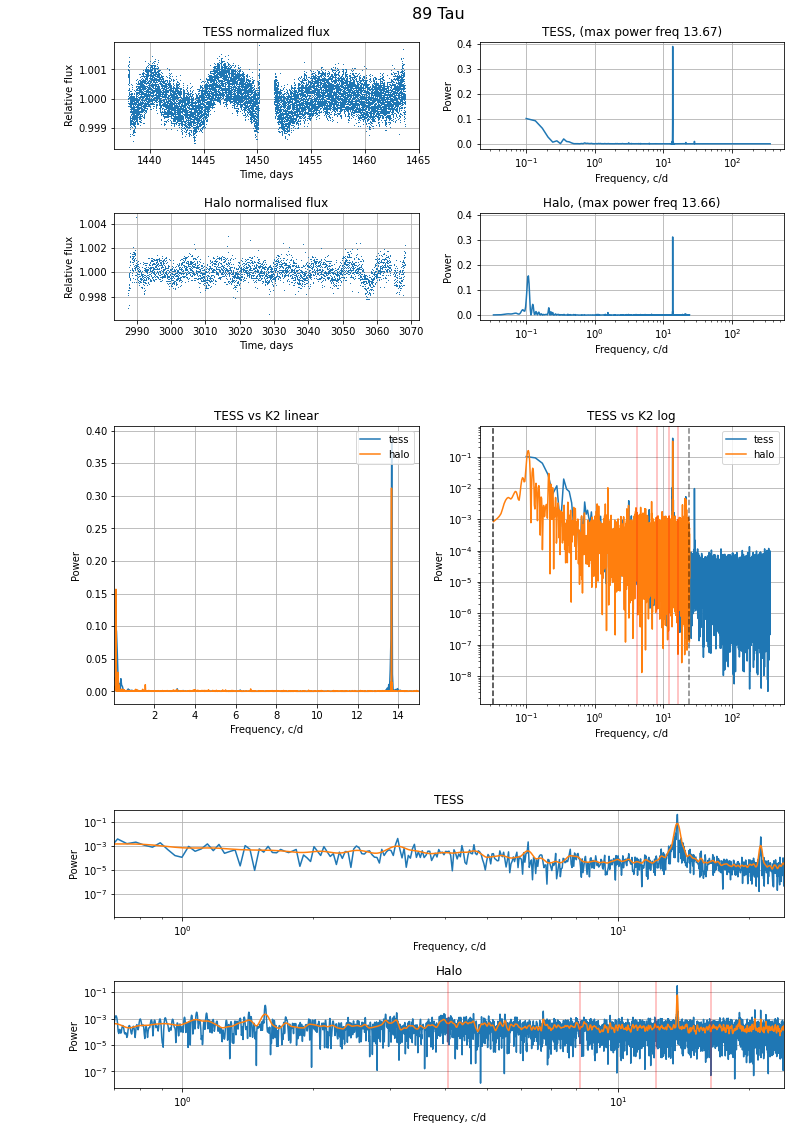

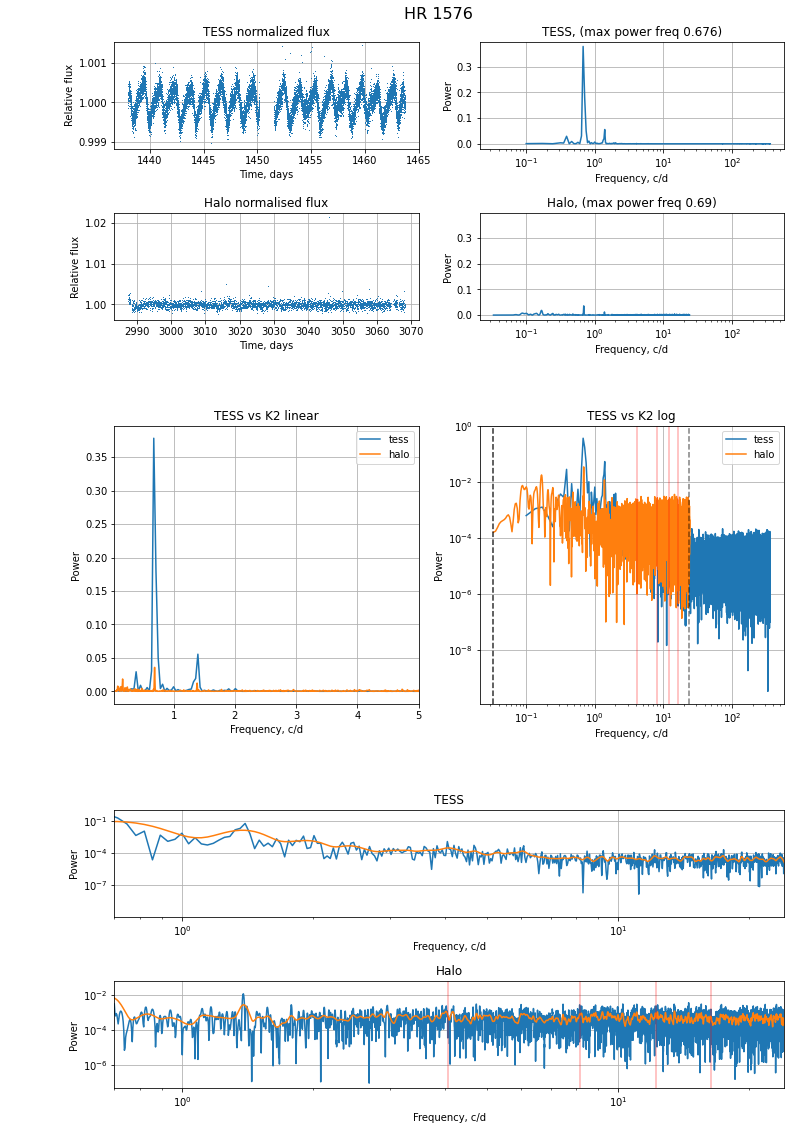

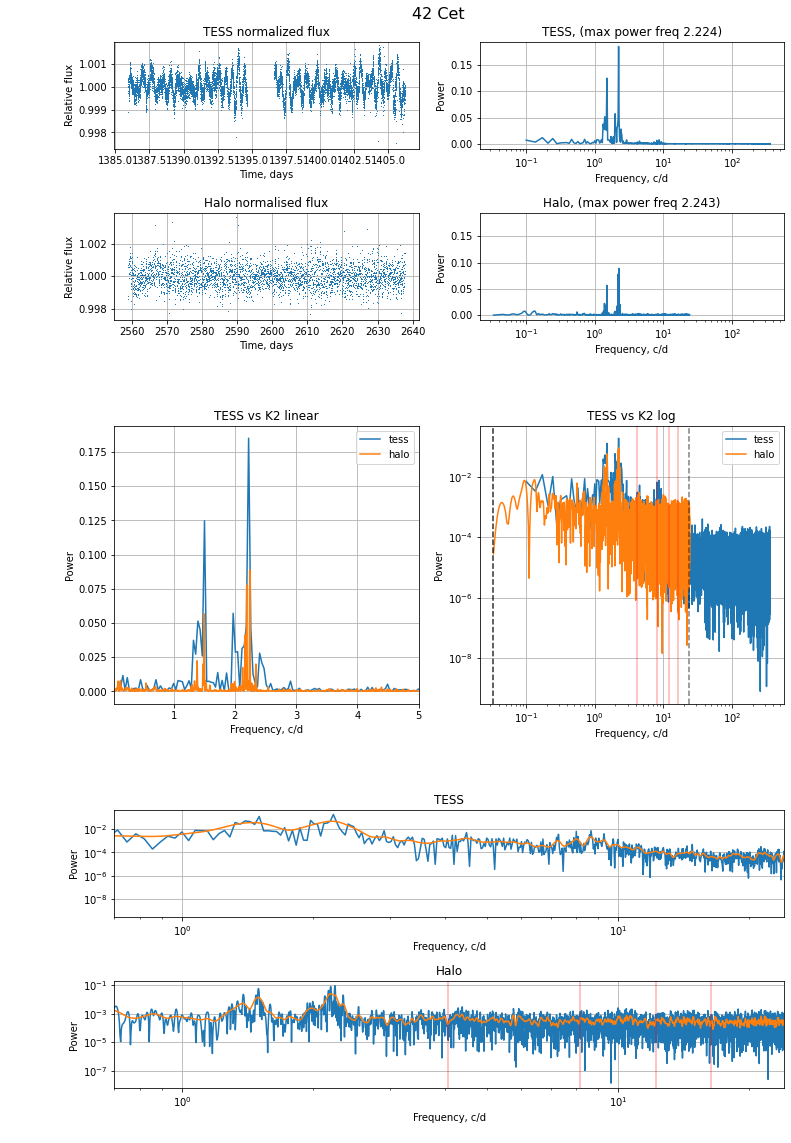

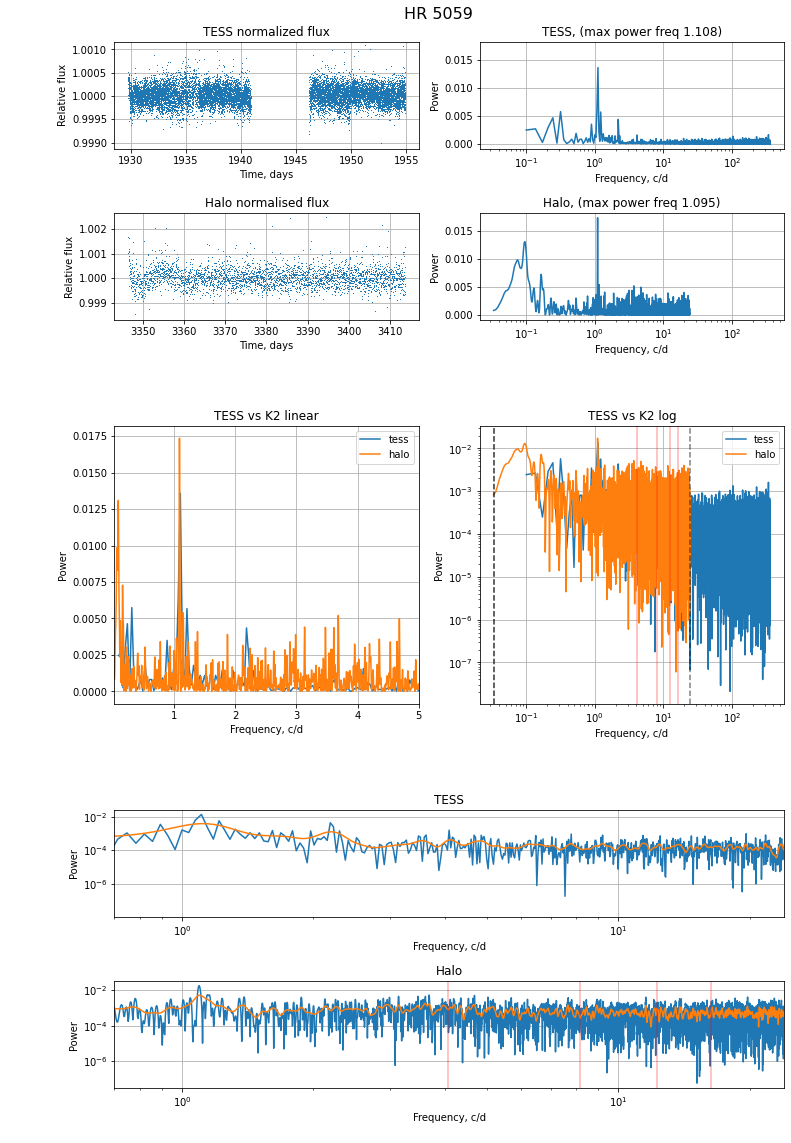

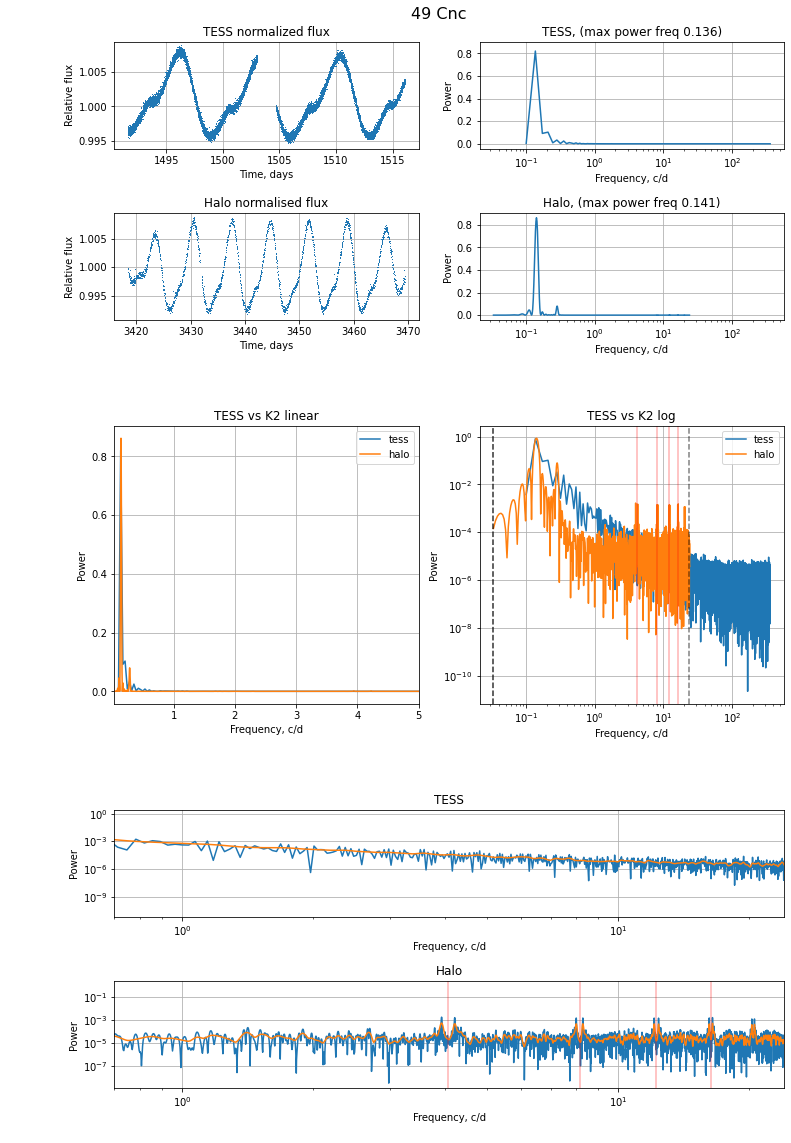

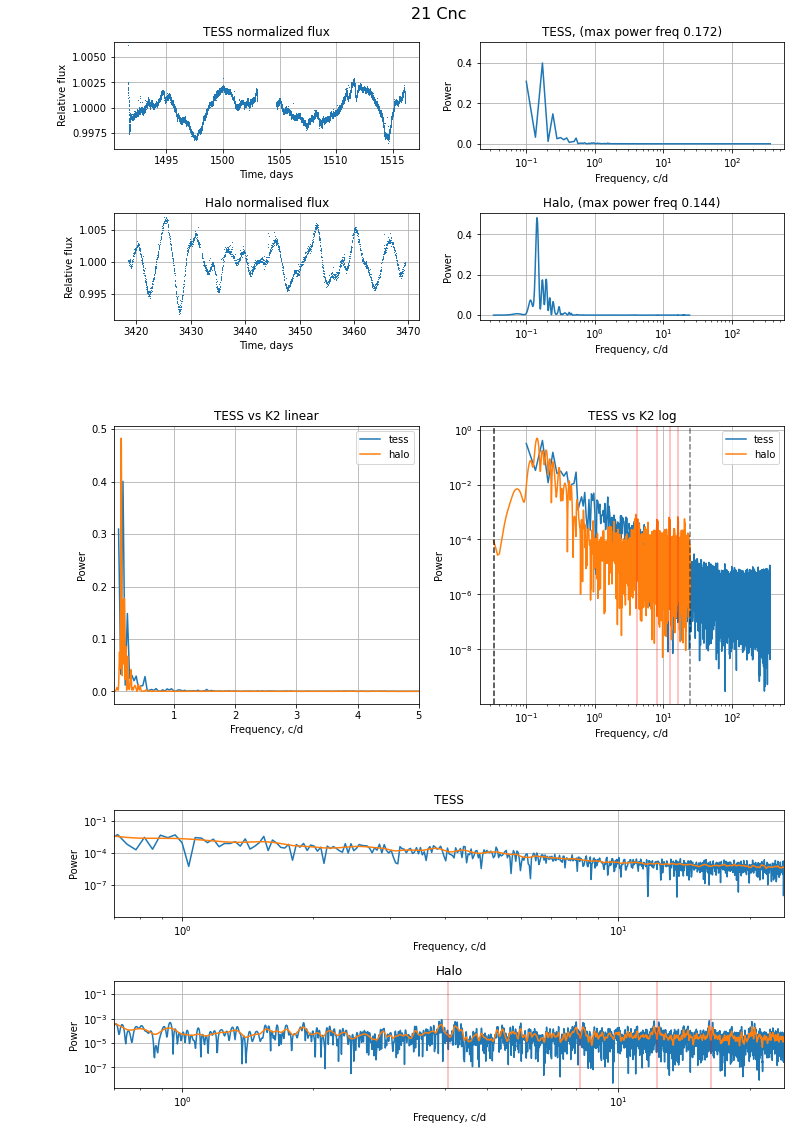

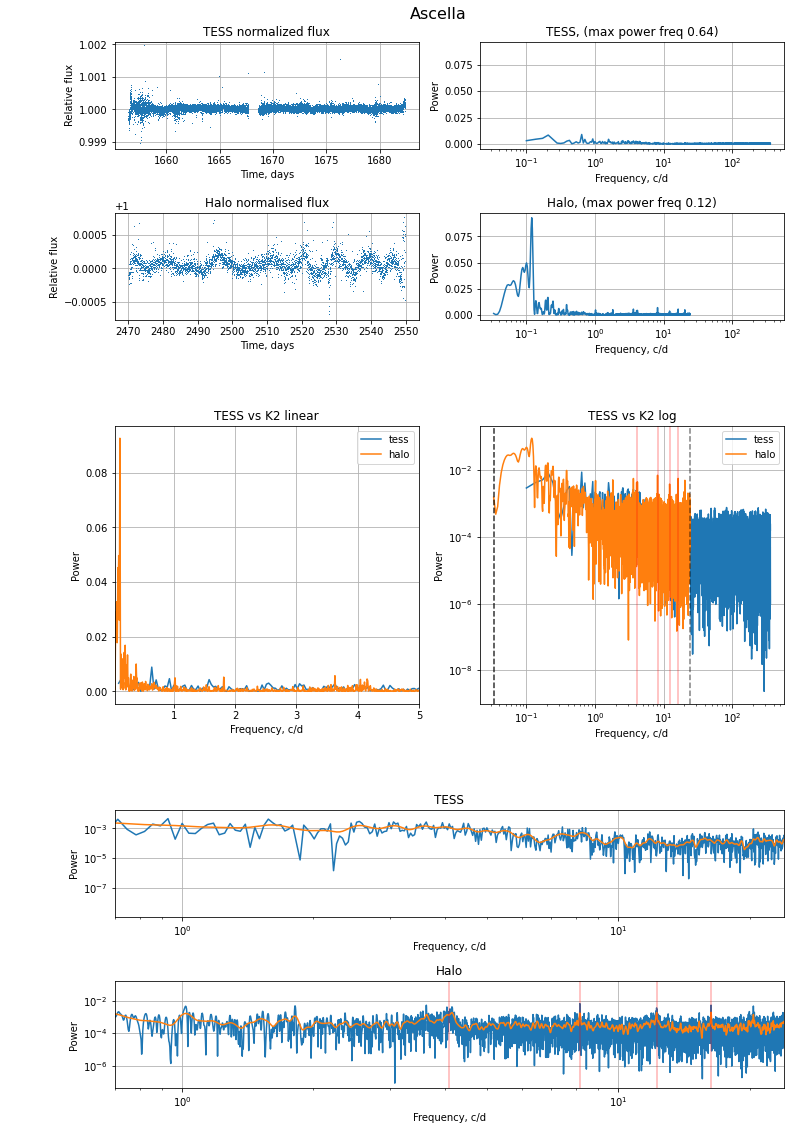

In [164]:
for index, row in observed_stars.iterrows():
    print(row["Name"], row["EPIC ID"], end='')
    
    name = row["Name"]
    epic_id = row["EPIC ID"]

    #download tess

    lc_search = lk.search_lightcurve(name,exptime=120)
    if len(lc_search) == 0:
        print(' No TESS data')
        continue
        
    lc = lc_search.download_all()
        
    lc[0] = lc[0].remove_nans().normalize()
    tess_time = lc[0].time.value
    tess_flux = lc[0].flux.value

    freqs_tess = np.linspace((1/10.),360.,10000) # tess from 10 day period to 360 c/d nyquist
    ls_tess = LombScargle(tess_time, tess_flux, normalization='standard')
    power_tess = ls_tess.power(freqs_tess)
    max_freq_tess = np.round(freqs_tess[power_tess.argmax()], 3)

    tess_smothed_periodogram = ndimage.gaussian_filter1d(power_tess,3)
    
    #download halo

    halo_filename = Path('fits/hlsp_halo_k2_llc_%s_lc.fits' % epic_id)
    try:
        halo = Table.read(halo_filename)
    except FileNotFoundError:
        print(' No HALO data')
        continue
        
    print('')

    m = np.isfinite(halo['corr_flux'])
    halo = halo[m]
    halo_flux = halo['flux']
    halo_time = halo['time']
    halo_corr_flux = halo['corr_flux']

    halo_normalized_flux = halo_corr_flux/np.nanmedian(halo_corr_flux)
    halo_trend = savgol(halo_corr_flux/np.nanmedian(halo_corr_flux),701,3)

    halo_lc = LombScargle(halo_time,halo_corr_flux/np.nanmedian(halo_corr_flux)-halo_trend+np.nanmedian(halo_trend),normalization='standard') #+np.nanmedian(halo_trend)
    freqs_halo = np.linspace((1/30.),24.,10000)
    power_halo = halo_lc.power(freqs_halo)
    max_freq_halo = np.round(freqs_halo[power_halo.argmax()], 3)
    
    halo_smothed_periodogram = ndimage.gaussian_filter1d(power_halo,10)
    
    
    
    #MAKE PLOTS 
    
    fig = plt.figure(figsize=(12.0,16))
    fig.subplots_adjust(top=0.85)
    
    fig.suptitle(name, fontsize=16)
    
    figs = fig.subfigures(nrows=3, ncols=1)
    
    fig1 = figs[0]
    fig1.subplots_adjust(hspace=0.6)
    ax1 = fig1.add_subplot(221)
    plt.plot(tess_time, tess_flux, ',')
    plt.yscale('linear')
    plt.ylabel('Relative flux')
    plt.xlabel('Time, days')
    plt.title('TESS normalized flux')
    plt.grid(True)

    ax2 = fig1.add_subplot(222)
    plt.plot(freqs_tess, power_tess)
    plt.xscale('log')
    plt.ylabel('Power')
    plt.xlabel('Frequency, c/d')
    plt.title('TESS, (max power freq %s)' %max_freq_tess)
    plt.grid(True)

    ax3 = fig1.add_subplot(223)
    plt.plot(halo_time, halo_corr_flux/np.nanmedian(halo_corr_flux)-halo_trend+np.nanmedian(halo_trend), ',')
    plt.yscale('linear')
    plt.ylabel('Relative flux')
    plt.xlabel('Time, days')
    plt.title('Halo normalised flux')
    plt.grid(True)

    ax4 = fig1.add_subplot(224, sharex=ax2, sharey=ax2)
    plt.plot(freqs_halo, power_halo)
    plt.xscale('log')
    plt.ylabel('Power')
    plt.xlabel('Frequency, c/d')
    plt.title('Halo, (max power freq %s)' %max_freq_halo)
    plt.grid(True)

    fig2 = figs[1]
    ax8 = fig2.add_subplot(121)
    plt.plot(freqs_tess, power_tess, label="tess")
    plt.plot(freqs_halo, power_halo, label="halo")
    if name == "89 Tau":
        plt.xlim(1/30., 15.)
    elif name == "rho Tau":
        plt.xlim(1/30., 30.)
    else:
        plt.xlim(1/30., 5.)
    plt.ylabel('Power')
    plt.xlabel('Frequency, c/d')
    plt.legend(loc="upper right", )
    plt.title('TESS vs K2 linear')
    plt.grid(True)

    ax9 = fig2.add_subplot(122)
    plt.plot(freqs_tess, power_tess, label="tess")
    plt.plot(freqs_halo, power_halo, label="halo")
    plt.legend(loc="upper right", )
    plt.axvline(1/30., alpha=0.5,linestyle='--',color='k')
    plt.axvline(24., alpha=0.5,linestyle='--',color='k') 
    #thruster fire harmonics
    plt.axvline(1/30., alpha=0.5,linestyle='--',color='k')
    plt.axvline(4.08, alpha=0.3,linestyle='-',color='r')
    plt.axvline(8.16, alpha=0.3,linestyle='-',color='r')
    plt.axvline(12.24, alpha=0.3,linestyle='-',color='r')
    plt.axvline(16.32, alpha=0.3,linestyle='-',color='r')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('Power')
    plt.xlabel('Frequency, c/d')
    plt.title('TESS vs K2 log')
    plt.grid(True)
    
    
    fig3 = figs[2]
    #fig3.suptitle('Smoothed', fontsize=16)
    ax5 = fig3.add_subplot(211)
    plt.plot(freqs_tess, power_tess, freqs_tess, tess_smothed_periodogram)
    plt.xlim(0.7, 24.)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('TESS')
    plt.ylabel('Power')
    plt.xlabel('Frequency, c/d')
    plt.grid(True)

    ax6 = fig3.add_subplot(212)
    plt.plot(freqs_halo, power_halo, freqs_halo, halo_smothed_periodogram)
    plt.axvline(4.08, alpha=0.3,linestyle='-',color='r')
    plt.axvline(8.16, alpha=0.3,linestyle='-',color='r')
    plt.axvline(12.24, alpha=0.3,linestyle='-',color='r')
    plt.axvline(16.32, alpha=0.3,linestyle='-',color='r')
    plt.xlim(0.7, 24.)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Halo')
    plt.ylabel('Power')
    plt.xlabel('Frequency, c/d')
    plt.grid(True)
    
    pp = PdfPages('reports/%s_%s.pdf' % (epic_id, name))
    pp.savefig(fig)
    pp.close()